In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.modeling.loggers import Logger
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
from flowprintOptimal.sekigo.ood.datasets import SineWaveDataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import TransformerGenerator,CNNNetwork,CNNNetwork1D
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler, FixedLengthSimpleSampler
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation
from typing import List
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset,BaseFlowDataset,DDQNActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import getValidInvalidStartingPointsForSubFlowStart, getActivityArrayFromFlow
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D
from flowprintOptimal.sekigo.modeling.loggers import Logger
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from typing import List
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder,State
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from torch.nn.utils.rnn import pack_sequence, unpack_sequence
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LinearPredictor
import warnings
from flowprintOptimal.sekigo.utils.commons import augmentData
warnings.filterwarnings('ignore')
import torch.nn.functional as F

In [2]:
train_dataset = SineWaveDataset(freq_range= (.2,1), phase_range= (.2,1), num_timesteps= 30,dataset_length= 5000,ts_dim= 1)
ood_dataset = SineWaveDataset(freq_range= (.2,1), phase_range= (.2,1), num_timesteps= 30,dataset_length= 5000,ts_dim= 1,is_sin= False)
logger = Logger(verbose= True)
logger.default_step_size = 500

In [2]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Download",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Download",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


True

In [2]:
flows = loadFlows(path= "data/VNAT/flowStore/vnatflows1second_2_bands.json")
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)
FT_filtered_flows = list(filter(lambda x : x.class_type != "FT",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "FT",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

True

In [3]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .5,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= 1,min_activity_for_start_point= 25,sample_wise_train_ratio= .5, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .5,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'chat': 0.04990084542323348, 'control': 0.8745198463508322, 'streaming': 0.5}
overlapping points = 0
{'FT': 1}
overlapping points = 0


In [4]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,all_flows["train_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,all_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["test_flows"])).value_counts())

all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None,do_aug= False)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None,do_aug= False)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["test_flows"],label_to_index= None)
ood_support_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= ood_dataset.label_to_index)

streaming    8089
chat         7122
control      7062
Name: count, dtype: int64
control      2624
chat         2507
streaming    1636
Name: count, dtype: int64
FT    143
Name: count, dtype: int64
FT    496
Name: count, dtype: int64


In [63]:
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
classifier_ = LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=6,output_dim = len(train_dataset.label_to_index))
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = NNClassificationTrainer(classifier = classifier_,device= device,logger= logger)
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs=8,batch_size= 64,lr= .0001)

classification ---- 1 metric test_f1 = 0.16616615473218752
classification ---- 1 metric train_f1 = 0.14493991701488934
classification ---- 10 metric train_loss = 1.1045217633247375
classification ---- 20 metric train_loss = 1.104084575176239
classification ---- 30 metric train_loss = 1.102037751674652
classification ---- 40 metric train_loss = 1.1021390676498413
classification ---- 50 metric train_loss = 1.101678156852722
classification ---- 60 metric train_loss = 1.0979680299758912
classification ---- 70 metric train_loss = 1.0958973169326782
classification ---- 80 metric train_loss = 1.097759974002838
classification ---- 90 metric train_loss = 1.0958600640296936
classification ---- 100 metric train_loss = 1.0932633042335511
classification ---- 110 metric train_loss = 1.0918867707252502
classification ---- 120 metric train_loss = 1.0914819717407227
classification ---- 130 metric train_loss = 1.0891697764396668
classification ---- 140 metric train_loss = 1.0874536037445068
classificati

In [64]:
def getEnergies(classifier,dataset,T = 1):
    loader = DataLoader(dataset,batch_size = 64)
    energies = []
    with torch.no_grad():
        for batch in loader:
            model_out = classifier(batch["data"].float().to(device))[0]
            #print(torch.exp(model_out/T).sum(dim= -1))

            batch_energies = (torch.log(torch.exp(model_out/T).sum(dim= -1))*-T).cpu().numpy().tolist()
            energies.extend(batch_energies)
    
    return np.array(energies)



In [65]:
in_energies = getEnergies(classifier= classifier_,dataset= train_dataset)
out_energies = getEnergies(classifier= classifier_,dataset= ood_dataset)

(array([ 10.,  28., 130., 235.,  41.,  24.,   5.,   7.,  10.,   6.]),
 array([-4.30131721, -4.12122612, -3.94113503, -3.76104393, -3.58095284,
        -3.40086174, -3.22077065, -3.04067955, -2.86058846, -2.68049736,
        -2.50040627]),
 <BarContainer object of 10 artists>)

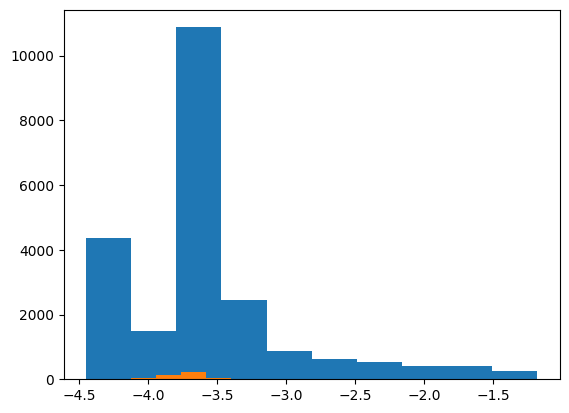

In [66]:
plt.hist(in_energies)
plt.hist(out_energies)

(array([  3.,   0.,   0., 195., 122.,  48.,  26.,  29.,  37.,  36.]),
 array([-5.15457582, -4.77575191, -4.396928  , -4.01810409, -3.63928018,
        -3.26045626, -2.88163235, -2.50280844, -2.12398453, -1.74516062,
        -1.3663367 ]),
 <BarContainer object of 10 artists>)

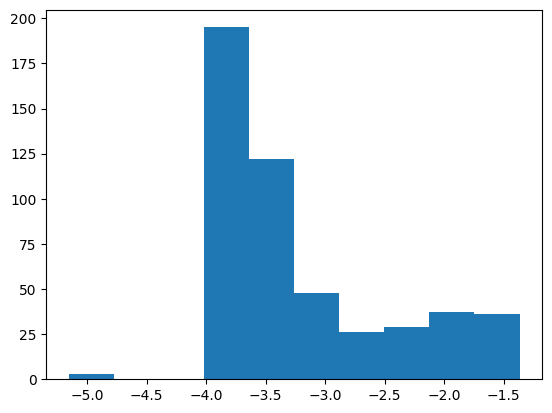

In [70]:
logger = Logger(name= "GAN",verbose= True)
logger.default_step_size = 500
random_dim,seq_len = 8*2,30
data_dim = 6
generator = TransformerGenerator(random_dim= random_dim,embedding_dim= 64,num_heads= 4, num_layers= 6,output_dim= data_dim,out_layer= nn.Sigmoid(),seq_len= seq_len)
#discriminator = CNNNetwork(num_filters= 32, kernel_sizes= [3,5,7],ts_dim= 1,output_dim= 1)

discriminator = CNNNetwork1D(in_channels= data_dim, num_filters= 32,output_dims = [1],num_layers= 4)
#classifier = CNNNetwork1D(in_channels= data_dim, num_filters= 64,output_dims = [len(train_dataset.label_to_index) + 1],num_layers= 3)#LSTMNetwork(lstm_hidden_size= 128,lstm_input_size= data_dim,output_dim = len(train_dataset.label_to_index) + 1)

In [71]:
trainer = GANTrainer(generator= generator,discriminator=discriminator,is_img=False,device= device,compile= True,grad_clip= 10,random_dim= random_dim,seq_len= seq_len,logger= logger)

In [ ]:
trainer.train(train_dataset= train_dataset,ood_dataset= ood_dataset,epochs= 500,batch_size= 128,lr_generator= 1e-4,n_critic= 4,lr_discriminator= 1e-4,gp_weight=  1) 

In [50]:
discriminator.load_state_dict(torch.load("models/discriminators/discriminator.pt"))

<All keys matched successfully>

In [16]:
def getScores(dataset,discriminator):
    loader = DataLoader(dataset,batch_size = 128)
    scores,labels = [],[]
    with torch.no_grad():
        for batch in loader:
            batch_scores = discriminator(batch["data"].float().to(device))[0].cpu().numpy()[:,0].tolist()
            scores.extend(batch_scores)
            labels.extend(batch["label"].numpy().tolist())
            
    return np.array(scores),np.array(labels)
        

In [17]:
id_scores,id_labels = getScores(dataset= train_dataset, discriminator= discriminator)
ood_scores,ood_labels = getScores(dataset= ood_dataset,discriminator= discriminator)

In [18]:
all_scores,all_labels = getScores(dataset= all_test_dataset,discriminator= discriminator)

In [19]:
predicted_ood_labels = all_labels[all_scores < (id_scores.mean() - 1.1*id_scores.std())]

In [20]:
all_train_dataset.label_to_index

{'Video': 0, 'Conferencing': 1, 'Download': 2, 'Upload': 3}

In [21]:
pd.Series(predicted_ood_labels).value_counts()

0    1041
3     128
1     101
2      24
Name: count, dtype: int64

In [22]:
id_scores.mean() - id_scores.std()

-0.25249648732942087

(array([2.2000e+01, 4.9400e+02, 2.2160e+03, 4.1190e+03, 5.4205e+04,
        1.5283e+04, 8.5400e+02, 4.4200e+02, 2.2100e+02, 1.3200e+02]),
 array([-2.15004349, -0.99257755,  0.16488838,  1.32235432,  2.47982025,
         3.63728619,  4.79475212,  5.95221806,  7.10968399,  8.26714993,
         9.42461586]),
 <BarContainer object of 10 artists>)

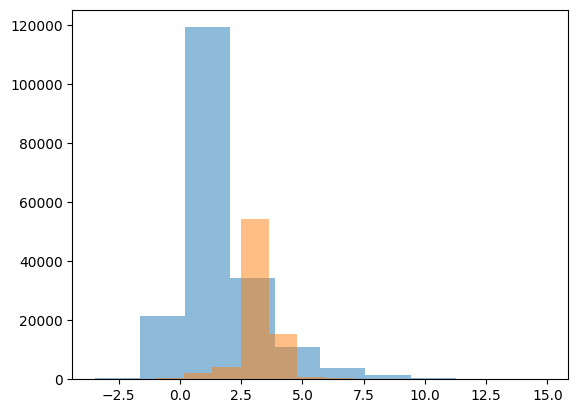

In [23]:
plt.hist(id_scores,alpha = .5)
plt.hist(ood_scores,alpha = .5)



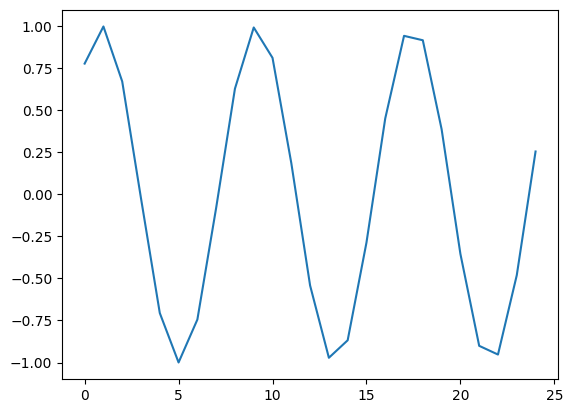

In [11]:
index = np.random.randint(len(train_dataset))
plt.plot(train_dataset[index]["data"][:,0])

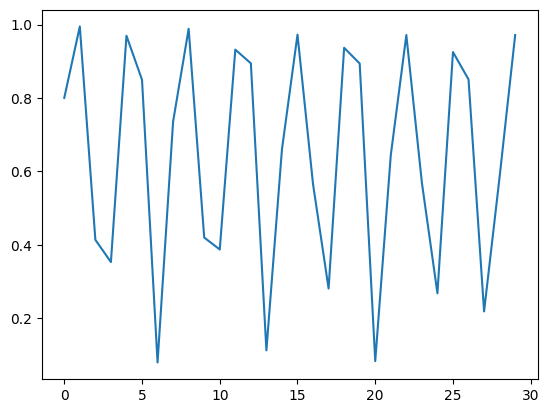

In [10]:
with torch.no_grad():
    generator.eval()
    generated = generator.to(device)(trainer.generateRandomZ(batch_size= 1))[0][0,:,0].cpu()
plt.plot(generated)

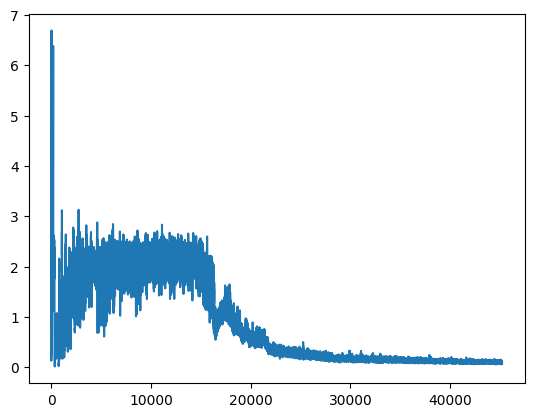

In [ ]:
plt.plot(logger.getMetric("gp_loss"))

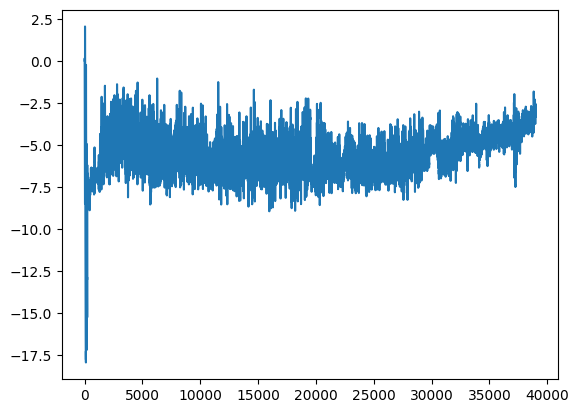

In [ ]:
plt.plot(logger.getMetric("cost_wd"))

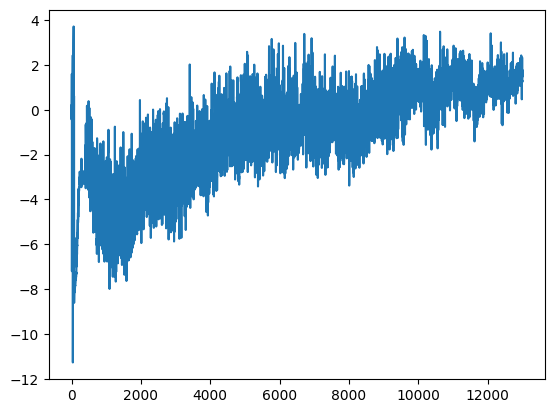

In [ ]:
plt.plot(logger.getMetric("generator_loss"))